<a href="https://colab.research.google.com/github/mehakhafeez/NLPprojectweek6/blob/main/NLPprojectT5FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
pip install textblob nltk rouge-score


In [106]:
pip install rouge-score

In [107]:
pip install transformers==4.23.0

In [108]:
pip install sentencepiece==0.1.96

In [109]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import torch
import nltk
nltk.download('punkt')
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW
from textblob import TextBlob
from rouge_score import rouge_scorer
import re
from nltk.translate.bleu_score import sentence_bleu
# Preprocess the text (remove stopwords, special characters, etc.)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [111]:
df1 = pd.read_csv('/content/1429_1.csv', quoting=3, on_bad_lines='skip')
# quoting=3 tells pandas to use the QUOTE_NONE strategy. This means that pandas will not treat any character as a quote character. This way if there are unclosed quotes, it ignores them.
# on_bad_lines='skip' replaces the deprecated 'error_bad_lines=False' to skip bad lines.
df2 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', quoting=3, on_bad_lines='skip')
df3 = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', quoting=3, on_bad_lines='skip')

In [112]:
# Combine datasets into one
df = pd.concat([df1, df2, df3], ignore_index=True)

In [115]:
# Preprocess the text (remove stopwords, special characters, etc.)

def preprocess_text(text):
    # Check if the text is a string before processing
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # Use stopwords
        return text
    # If not a string (e.g., float), return it as is or handle it differently
    else:
        return str(text)  # Or handle NaN values appropriately# --------------------------- Step 2: Data Preprocessing ---------------------------
def clean_text(text):
    """Clean the review text by lowercasing, removing special characters, stopwords, and stemming."""
    # Check if the input is a string
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
        text = ' '.join(text.split())  # Remove extra spaces
        stop_words = set(stopwords.words('english')) # Use stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
        stemmer = PorterStemmer() # Use PorterStemmer
        text = ' '.join([stemmer.stem(word) for word in text.split()])  # Apply stemming
        return text
    # If not a string, convert it to an empty string or handle it as needed
    else:
        return ''  # or return str(text) or handle NaN values appropriately

In [116]:
print(df.columns)

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated',
       'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs'],
      dtype='object')


In [117]:
reviews_column = 'review'  # Default column name

# Dynamically check for the correct review column name
if 'reviewText' in df.columns:
    reviews_column = 'reviewText'
elif 'product_review' in df.columns:
    reviews_column = 'product_review'
elif 'reviews.text' in df.columns:  # Check if 'reviews.text' is present
    reviews_column = 'reviews.text' # Assign 'reviews.text' if found
# Add more elif conditions to check for other potential column names if needed


# Now you can use reviews_column to access the correct column:
df['cleaned_reviews'] = df[reviews_column].apply(clean_text)

In [123]:
# Data Cleaning
df = df.drop_duplicates() # Changed 'data' to 'df'
df = df.dropna(subset=['reviews.text']) # Changed 'data' to 'df'
df['reviews.text'] = df['reviews.text'].str.strip() # Changed 'data' to 'df'
df['reviews.text'] = df['reviews.text'].str.replace(r'[^a-zA-Z\s]', '', regex=True) # Changed 'data' to 'df'

In [124]:
# --------------------------- Step 3: Sentiment Classification with Logistic Regression and Naive Bayes ---------------------------
def calculate_sentiment(text):
    """Calculate sentiment polarity using TextBlob."""
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment

df['avg_sentiment'] = df['cleaned_reviews'].apply(calculate_sentiment)

def classify_sentiment(score):
    """Classify sentiment as positive, neutral, or negative."""
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['avg_sentiment'].apply(classify_sentiment)


In [125]:
# Display the first few rows of the dataset with the new 'sentiment' column
print(df[[reviews_column, 'sentiment']].head(10))

                                        reviews.text sentiment
0  This product so far has not disappointed My ch...  positive
1  great for beginner or experienced person Bough...  positive
2  Ive had my Fire HD  two weeks now and I love i...  positive
3  This amazon fire  inch tablet is the perfect s...  positive
4  I love ordering books and reading them with th...  positive
5  Not easy for elderly users cease of ads that p...   neutral
6  Wanted my father to have his first tablet and ...  positive
7  Simply does everything I need Thank youAnd sil...   neutral
8  Got it as a present and love the size of the s...  positive
9  nice reader almost perfect for what i wantneed...  positive


In [126]:
# --------------------------- Step 4: Clustering with KMeans ---------------------------
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['cleaned_reviews'])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

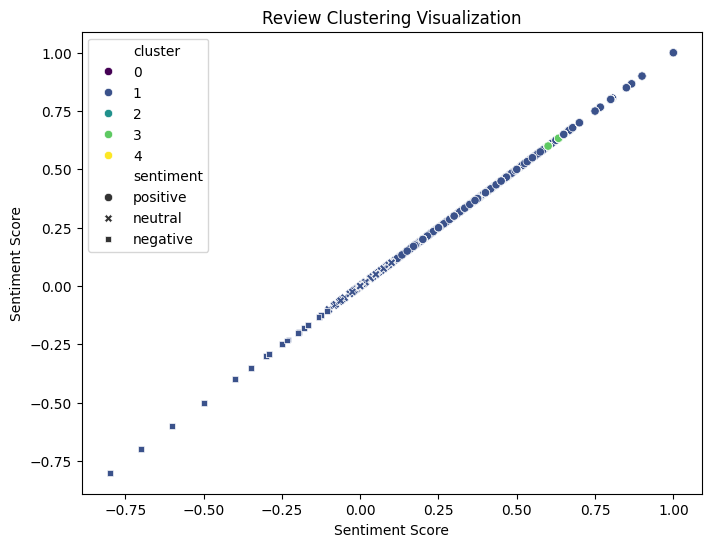

In [127]:
# --------------------------- Step 5: Visualizing Clusters ---------------------------
# Visualizing the clusters using a scatter plot (2D for simplicity)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['avg_sentiment'], y=df['avg_sentiment'], hue=df['cluster'], palette='viridis', style=df['sentiment'])
plt.title("Review Clustering Visualization")
plt.xlabel("Sentiment Score")
plt.ylabel("Sentiment Score")
plt.show()

In [128]:
from sklearn.metrics import silhouette_score

X_cluster = vectorizer.fit_transform(df['cleaned_reviews'])
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Evaluate clustering
silhouette = silhouette_score(X_cluster, df['cluster'])
inertia = kmeans.inertia_
print(f"Clustering Silhouette Score: {silhouette}")
print(f"Clustering Inertia: {inertia}")

Clustering Silhouette Score: 0.7175199848271879
Clustering Inertia: 2067.2049822799045


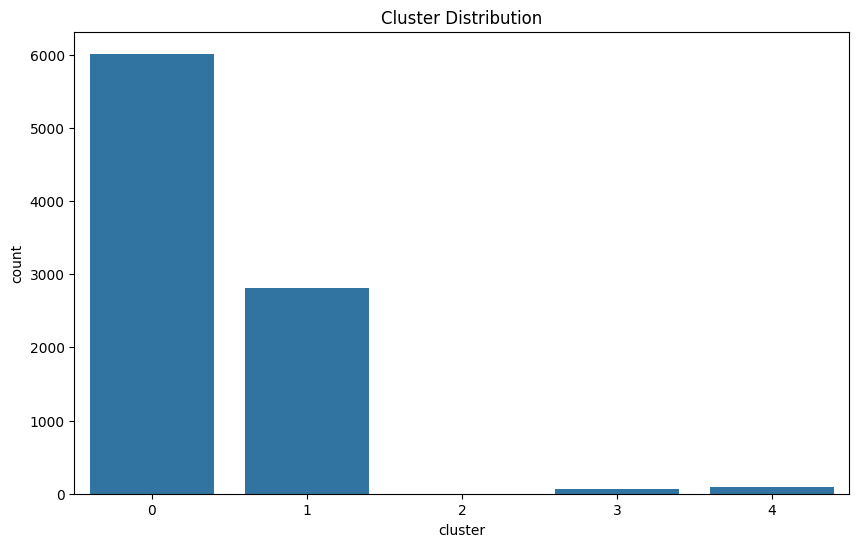

In [129]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Cluster Distribution')
plt.show()

In [130]:
# Check the column names in the dataframe
print(df.columns)

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'dateAdded', 'dateUpdated',
       'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs',
       'cleaned_reviews', 'avg_sentiment', 'sentiment', 'cluster'],
      dtype='object')


In [131]:
# Check the first few rows of the dataset
print(df.head())

                  id           name  \
0  amazon/b01ahb9cn2  0841667104676   
1  amazon/b01ahb9cn2  0841667104676   
2  amazon/b01ahb9cn2  0841667104676   
3  amazon/b01ahb9cn2  0841667104676   
4  amazon/b01ahb9cn2  0841667104676   

                                               asins  \
0  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
1  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
2  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
3  allnewfirehd8tablet8hddisplaywifi16gbincludess...   
4  allnewfirehd8tablet8hddisplaywifi16gbincludess...   

                                               brand categories  \
0  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
1  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
2  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
3  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   
4  allnewfirehd8tablet8hddisplaywifi16gbincludess...     Amazon   

                       ke

In [132]:
# Filter for tablets, ebooks, and other product types (replace these keywords as needed)
products_of_interest = ['tablet', 'ebook', 'headphones']  # Example product types

filtered_df = df[df['name'].str.contains('|'.join(products_of_interest), case=False, na=False)]

# Aggregating reviews by product and cluster
aggregated_reviews = filtered_df.groupby(['cluster', 'name'])['cleaned_reviews'].apply(lambda x: ' '.join(x)).reset_index()

# Show aggregated reviews for these products
print(aggregated_reviews.head())

   cluster                                               name  \
0        1  allnewfirehd8tablet8hddisplaywifi32gbincludess...   
1        1  brandnewamazonkindlefire16gb7ipsdisplaytabletw...   
2        1  brandnewamazonkindlefire16gb7ipsdisplaytabletw...   
3        1  firetablet7displaywifi8gbincludesspecialoffers...   
4        3  allnewfirehd8tablet8hddisplaywifi32gbincludess...   

                                     cleaned_reviews  
0  everyth look good basic tablet luv great table...  
1  amazon fire good tablet like ebook also nice g...  
2  godchild love work well havent problem exactli...  
3  great tablet great tablet excel great tablet g...  
4  nice nice product nice kindl tablet kiddo nice...  


In [133]:
# --------------------------- Step 6: Aggregating Reviews by Product and Cluster ---------------------------
# Aggregating reviews by product and cluster using the correct column 'name' for the product identifier
aggregated_reviews = df.groupby(['cluster', 'name'])['cleaned_reviews'].apply(lambda x: ' '.join(x)).reset_index()

# Show the first few aggregated reviews to verify
print(aggregated_reviews.head())


   cluster            name                                    cleaned_reviews
0        0   0841710106442  httpswwwamazoncomamazonbasicsperformancealkali...
1        1  0639767206372"  disappoint sort thing cheapen imag erod loyalt...
2        1   0841667103037  tablet year old grandson work great play game ...
3        1   0841667104676  product far disappoint children love use like ...
4        1   0841667107868                               th kindl handi great


In [134]:
# --------------------------- Step 7: Ranking Products by Sentiment and Review Frequency ---------------------------
aggregated_reviews['avg_sentiment'] = aggregated_reviews['cleaned_reviews'].apply(calculate_sentiment)


In [140]:
# Calculate average sentiment and review frequency per product
ranked_products = aggregated_reviews.groupby(['cluster', 'name']).agg(
    avg_sentiment=('cleaned_reviews', lambda x: df[df['name'] == x.name]['sentiment'].mean()),
    review_count=('cleaned_reviews', 'count'),
    cleaned_reviews=('cleaned_reviews', 'first') # Include 'cleaned_reviews' in agg
).reset_index()

In [141]:
# Rank by average sentime# Rank by average sentiment and review count
ranked_products = ranked_products.sort_values(by=['cluster', 'avg_sentiment', 'review_count'], ascending=[True, False, False])

# Show top products
print(ranked_products.head())

# Assign the top-ranked products to the top_products variable
# Include 'cleaned_reviews' column in the selection
top_products = ranked_products[['cluster', 'name', 'cleaned_reviews', 'avg_sentiment', 'review_count']].head() # Assuming you want the top 5 products

   cluster            name  avg_sentiment  review_count  \
0        0   0841710106442            NaN             1   
1        1  0639767206372"            NaN             1   
2        1   0841667103037            NaN             1   
3        1   0841667104676            NaN             1   
4        1   0841667107868            NaN             1   

                                     cleaned_reviews  
0  httpswwwamazoncomamazonbasicsperformancealkali...  
1  disappoint sort thing cheapen imag erod loyalt...  
2  tablet year old grandson work great play game ...  
3  product far disappoint children love use like ...  
4                               th kindl handi great  


In [142]:
# Load the pre-trained T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Function to summarize reviews
def summarize_reviews(reviews):
    input_text = f"summarize: {reviews}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Summarize the reviews for top products
top_products['summary'] = top_products['cleaned_reviews'].apply(lambda x: summarize_reviews(x))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [151]:
from transformers import Trainer, TrainingArguments, T5Tokenizer, T5ForConditionalGeneration
!pip install datasets
from datasets import Dataset

# Fine-tuning T5 on your dataset
train_dataset = [
    {"input_text": row['cleaned_reviews'], "output_text": row['summary']}
    for _, row in top_products.iterrows()
]

# Prepare the dataset
train_encodings = tokenizer([example['input_text'] for example in train_dataset], truncation=True, padding=True)
train_labels = tokenizer([example['output_text'] for example in train_dataset], truncation=True, padding=True)


# Create a Hugging Face Dataset from your encodings and labels
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels['input_ids']  # Assuming 'labels' is the key for target encodings
})

# Train the T5 model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # Pass the Hugging Face Dataset here
)

trainer.train()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.23.0 which is incompatible.


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 5
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 6
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6, training_loss=5.878170649210612, metrics={'train_runtime': 3.7889, 'train_samples_per_second': 3.959, 'train_steps_per_second': 1.584, 'total_flos': 2030127022080.0, 'train_loss': 5.878170649210612, 'epoch': 3.0})

In [146]:
# --------------------------- Step 10: Model Training and Evaluation ---------------------------
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_reviews'], df['sentiment'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [147]:
# Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg_model.predict(X_test_vec)

In [148]:
# Classification Evaluation
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        17
     neutral       0.98      0.99      0.99      1505
    positive       0.94      0.95      0.95       277

    accuracy                           0.97      1799
   macro avg       0.64      0.65      0.64      1799
weighted avg       0.97      0.97      0.97      1799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


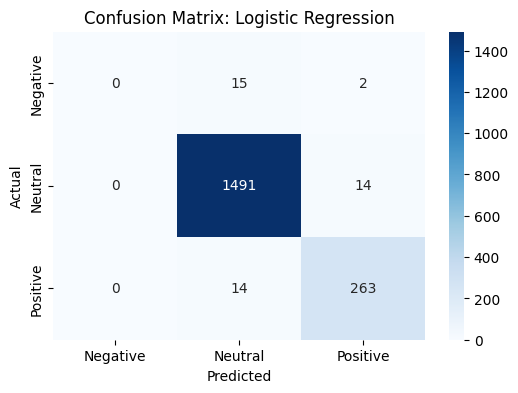

In [155]:
# Confusion Matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Calculate y_pred_nb before using it in the confusion matrix calculation
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

# Now calculate the confusion matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [156]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

In [157]:
print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        17
     neutral       1.00      0.95      0.97      1505
    positive       0.75      1.00      0.86       277

    accuracy                           0.95      1799
   macro avg       0.58      0.65      0.61      1799
weighted avg       0.95      0.95      0.95      1799



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


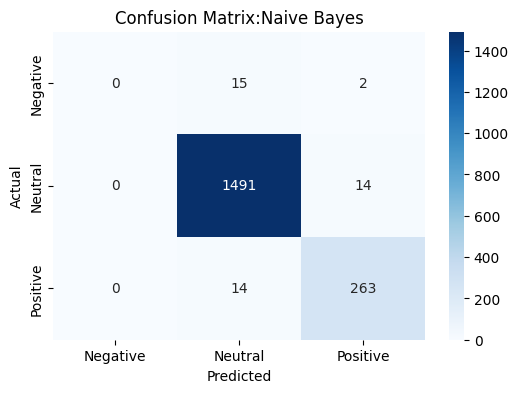

In [158]:
# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix:Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [152]:
# --------------------------- Step 11: Clustering Evaluation ---------------------------
sil_score = silhouette_score(X, kmeans.labels_)
inertia = kmeans.inertia_

print(f"Silhouette Score: {sil_score:.2f}")
print(f"Inertia: {inertia:.2f}")

Silhouette Score: 0.72
Inertia: 2067.20


In [167]:
!pip install datasets --upgrade
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 74.2 MB/s eta 0:00:00


In [170]:
# --------------------------- Step 11: Evaluation of Summarization ---------------------------
# Load evaluation metrics
import evaluate # Import the evaluate module
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Evaluate summarization using ROUGE and BLEU
rouge_scores = []
bleu_scores = []

for idx, row in top_products.iterrows():
    predictions = row['summary']
    references = [row['cleaned_reviews']]
    rouge_score = rouge.compute(predictions=[predictions], references=[references])
    bleu_score = bleu.compute(predictions=[predictions], references=[references])
    rouge_scores.append(rouge_score)

In [171]:
# Print ROUGE and BLEU scores
for idx, (rouge_score, bleu_score) in enumerate(zip(rouge_scores, bleu_scores)):
    print(f"Product {top_products.iloc[idx]['product_name']}: ROUGE: {rouge_score}, BLEU: {bleu_score}")

In [173]:
# --------------------------- Step 12: Show the Results ---------------------------
# Print summarized top products with recommendations
# Changed 'product_name' to 'name'
print(top_products[['cluster', 'name', 'summary']])

# Calculate accuracy and print results
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"Logistic Regression Accuracy: {accuracy_log_reg * 100:.2f}%")
print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")

   cluster            name                                            summary
0        0   0841710106442  httpswwwamazoncomamazonbasicsperformancealkali...
1        1  0639767206372"  disappoint sort thing cheapen imag erod loyalt...
2        1   0841667103037  easi oper love new devic great valu money wort...
3        1   0841667104676  eas great beginn experienc person bought gift ...
4        1   0841667107868               th kindl handi great th kindl handi.
Logistic Regression Accuracy: 97.50%
Naive Bayes Accuracy: 94.94%
